In [10]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.get_datasets import get_test_set
from core.util.trefor_dataset import TreforData
from core.models import LSTM
from core.models.model_training import blocked_training, test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
from core.util.early_stop import EarlyStop

Set global parameters.

In [11]:
# To be modified depending on gridsearch result
batch_size = 128
learning_rate = 0.001
num_layers = 1
lookback = 36

# Extract hyperparameters configuration that will not be tuned upon
hidden_size, EPOCHS, horizon, lookback, loss_function, dropout_rate, folds = (
    get_hyperparameter_configuration()
)

Use CUDA (GPU) if available.

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

Initialize a very basic LSTM.

In [13]:
def get_model() -> nn.Module:
    """Get the model for training folds."""
    model = LSTM(
        input_size=1,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        horizon=horizon,
        lookback=lookback,
    )
    model.to(device)
    return model

Validate the training model on the validation set for each epoch.

In [14]:
early_stopper = EarlyStop(5, 0.05)
best_train_loss, best_val_loss, best_model = blocked_training(
    model=get_model(),
    learning_rate=learning_rate,
    device=device,
    batch_size=batch_size,
    early_stopper=early_stopper,
)


x_test, y_test = get_test_set(lookback=lookback, horizon=horizon, folds=folds)
test_dataset = TreforData(x_test, y_test, device)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


t_loss, predicted = test_model(
    best_model=best_model,
    loss_function=loss_function,
    testing_loader=testing_loader,
)

Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

## Visualize model performance
Visualize the training and validation loss.

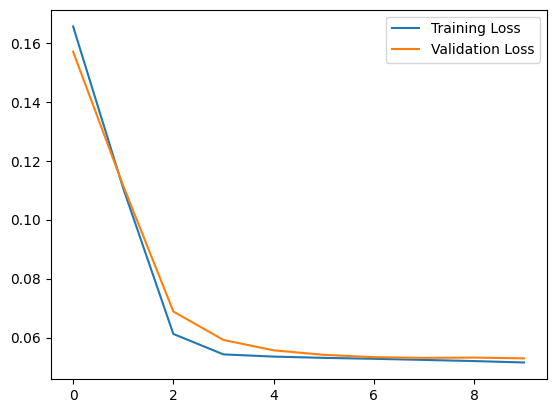

In [15]:
plt.clf()
plt.plot(best_train_loss, label="Training Loss")
plt.plot(best_val_loss, label="Validation Loss")
plt.legend()
plt.show()

Plot the actual values and predictions from the model on the validation set.

Plot predictions for the first 7 days in the validation set

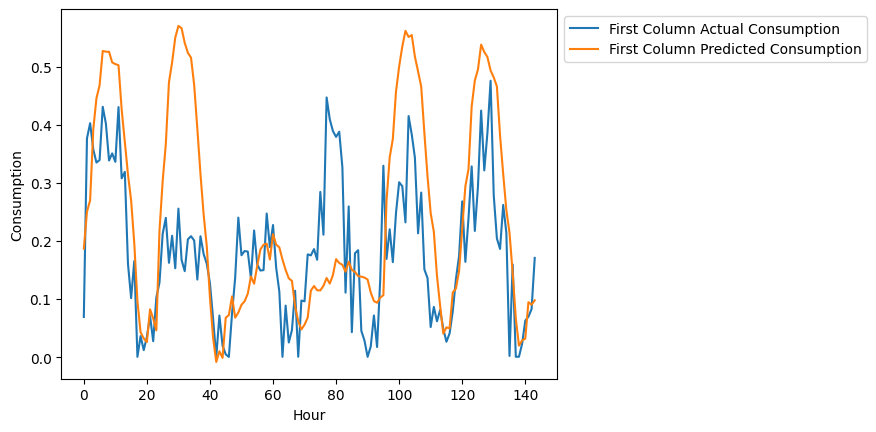

In [16]:
plot_predictions(0, 6, y_test, predicted)

Plot predictions for the last 7 days in the validation set

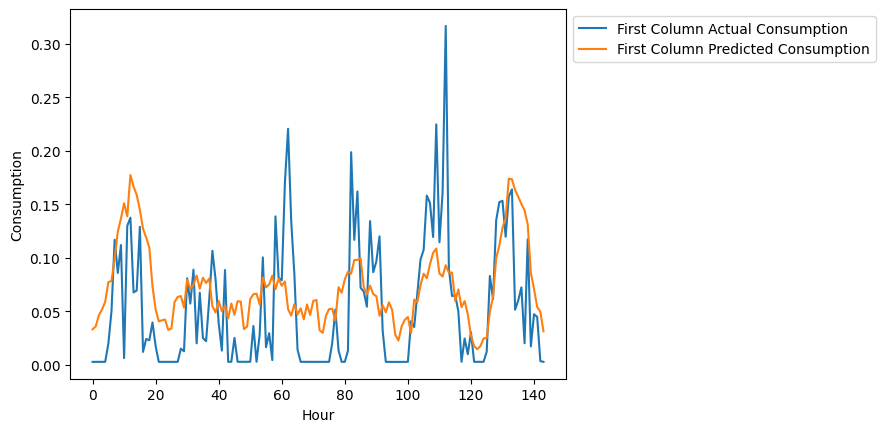

In [17]:
plot_predictions(-7, -1, y_test, predicted)

Plot predictions for 7 days in the in the middle of the validation set.

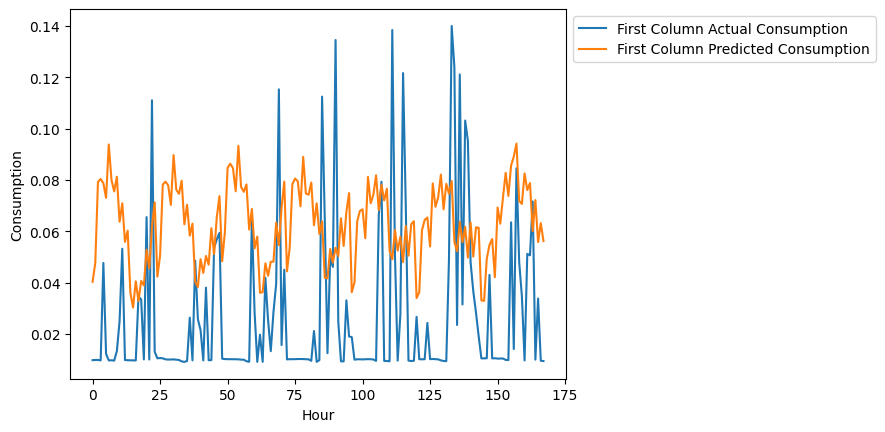

In [18]:
days_count = len(y_test) / 24
plot_predictions(int(days_count / 2), int(days_count / 2 + 7), y_test, predicted)